<a href="https://colab.research.google.com/github/jonsonboss/BEAR_AI/blob/main/BEAR_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install voila pyngrok fastai ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.0 MB/s eta 0:00:00
Mounted at /content/gdrive



--- Processing 'grizzly bear' ---
Searching for 'grizzly bear' images...
Verifying 29 images...
Found 29 valid images after verification.
Resizing 29 images to 224x224 using PIL...
Finished processing grizzly bear in bears/grizzly


--- Processing 'black bear' ---
Searching for 'black bear' images...
Verifying 26 images...
Found 26 valid images after verification.
Resizing 26 images to 224x224 using PIL...
Finished processing black bear in bears/black


--- Processing 'teddy bear' ---
Searching for 'teddy bear' images...
Verifying 30 images...
Found 30 valid images after verification.
Resizing 30 images to 224x224 using PIL...
Finished processing teddy bear in bears/teddy


All image data preparation complete!


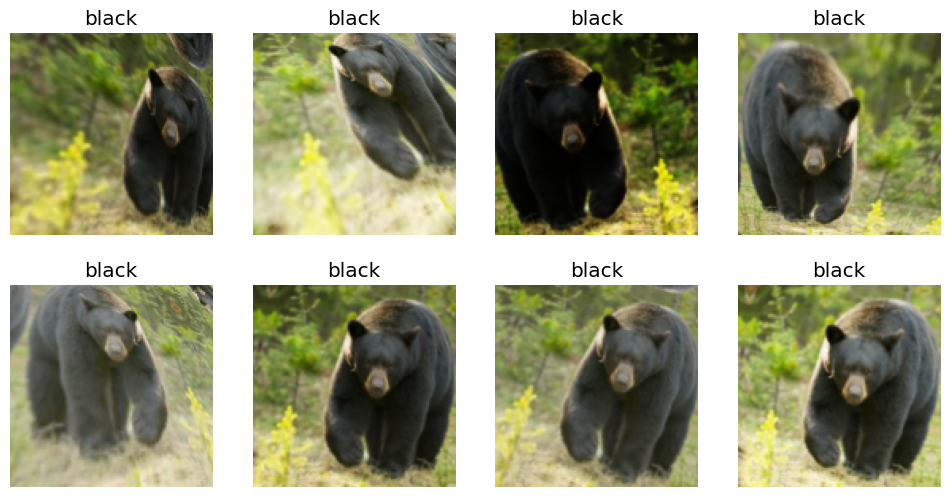

In [ ]:
!pip install ddgs fastai
import time
from fastcore.all import L
from ddgs import DDGS
from pathlib import Path
from fastai.vision.utils import download_images, verify_images
from fastai.vision.all import get_image_files
from PIL import Image

bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

# Loop for each type
for o in bear_types:
    dest = path / o
    dest.mkdir(exist_ok=True, parents=True)

    print(f"\n--- Processing '{o} bear' ---")
    print(f"Searching for '{o} bear' images...")

    try:
        with DDGS() as ddgs:
            max_imgs_per_type = 30  # Keeping max_results at 30

            if o == 'grizzly':
                results_gen = ddgs.images(
                    f"{o} bear -polar -black -white -cub",
                    region="wt-wt",
                    safesearch="off",
                    max_results=max_imgs_per_type,
                )
            elif o == 'black':
                results_gen = ddgs.images(
                    f"{o} bear -grizzly -polar -white -cub",
                    region="wt-wt",
                    safesearch="off",
                    max_results=max_imgs_per_type,
                )
            elif o == 'teddy':
                results_gen = ddgs.images(
                    f"{o} bear -grizzly -polar -black -animal",
                    region="wt-wt",
                    safesearch="off",
                    max_results=max_imgs_per_type,
                )
            else:
                results_gen = ddgs.images(
                    f"{o} bear",
                    region="wt-wt",
                    safesearch="off",
                    max_results=max_imgs_per_type,
                )

            urls = L(list(results_gen)).itemgot("image")

        download_images(dest, urls=urls)

        img_files_initial = get_image_files(dest)
        print(f"Verifying {len(img_files_initial)} images...")
        verify_images(img_files_initial).map(Path.unlink)

        img_files_to_resize = get_image_files(dest)
        print(f"Found {len(img_files_to_resize)} valid images after verification.")

        print(f"Resizing {len(img_files_to_resize)} images to 224x224 using PIL...")
        for img_path in img_files_to_resize:
            try:
                with Image.open(img_path) as img:
                    if img.mode == 'P' and 'transparency' in img.info:
                        img = img.convert('RGBA')
                    elif img.mode != 'RGB':
                        img = img.convert('RGB')

                    img = img.resize((224, 224))
                    img.save(img_path)
            except FileNotFoundError:
                print(
                    f"Warning: File not found during resize (already deleted?): {img_path}. Skipping."
                )
                continue
            except Exception as e:
                print(f"Warning: Could not resize {img_path}. Error: {e}. Removing file.")
                img_path.unlink(missing_ok=True)

    except Exception as e:
        print(f"An error occurred while processing '{o} bear': {e}")
        print("Waiting even longer before retrying or moving to the next category...")
        time.sleep(90)  # Significant wait if an error occurs
        continue

    print(f"Finished processing {o} bear in {dest}\n")

    # --- IMPORTANT: This was previously 35 seconds, now increased to 60 seconds ---
    time.sleep(60)

print("\nAll image data preparation complete!")

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.872739,2.576940,0.411765,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.916323,1.616840,0.352941,00:00
1,1.950477,0.794386,0.294118,00:00
2,1.615569,0.489558,0.176471,00:00
3,1.367582,0.359602,0.117647,00:00


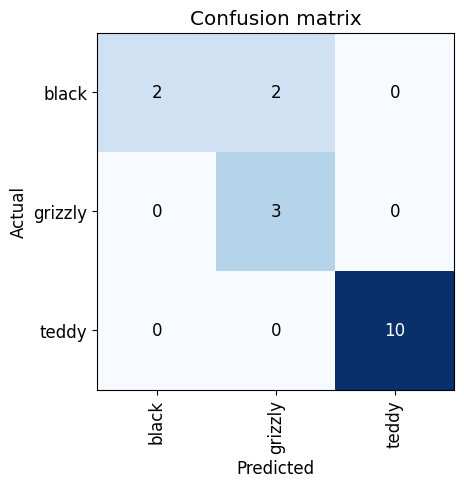

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

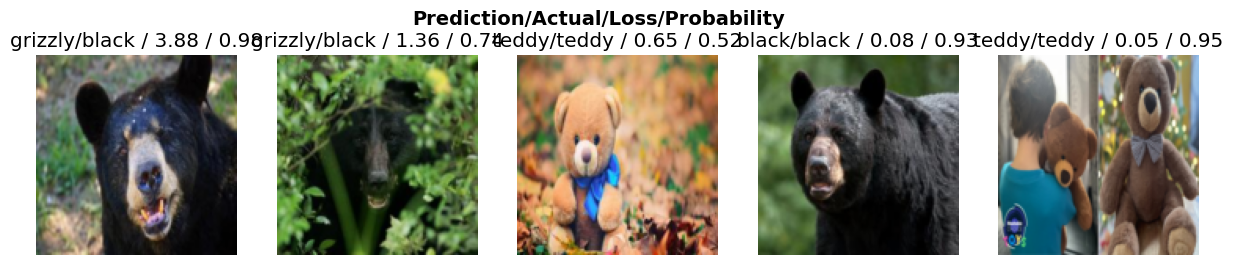

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9884')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])